In [1]:
# from qiskit import *
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.visualization import plot_state_qsphere, plot_state_city, plot_bloch_multivector
from qiskit.visualization import array_to_latex
import qiskit.quantum_info as qi

from qiskit_ionq import IonQProvider
# import gates
from qiskit_ionq import GPIGate, GPI2Gate, MSGate
from qiskit import Aer, execute, assemble

# numpy for linear algebra stuff
from numpy.random import randint, shuffle
import numpy as np
import matplotlib.pyplot as plt

# To supress the deprecation warnings
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
#%run utility_functions.ipynb

provider = IonQProvider("MSZ3nHSUkWvLg4YucxMDpNDESpGqQx3i")
native_simulator = provider.get_backend("ionq_simulator", gateset="native")

In [2]:
def Theta2(theta1):
    if theta1 <= np.pi/4:
        theta2 = 0.5 * np.arccos(np.cos(2*theta1)/np.sin(2*theta1))
    if theta1 > np.pi/4:
        theta2 = 0.5 * np.arccos(-np.cos(2*theta1)/np.sin(2*theta1))
    
    return theta2

def theta_maker(theta1):
    if (theta1 == np.pi/8) or (theta1 == 3*np.pi/8):
        theta2 = 0
        theta3 = 0
        return np.array([theta1, theta2, theta3])
    
    
    etaA = np.sin(2 * theta1)
    theta2 = Theta2(theta1)
    theta3 = np.arctan(np.tan(theta1) * np.tan(theta2))
    theta = np.array([theta1, theta2, theta3])
    return theta

In [3]:
def initial_state(qc, basis, bit_val):
    if basis == 'X' and bit_val == 1: # initial state is |->
        qc.append(GPIGate(0), [0])
        qc.append(GPI2Gate(1/4), [0])
        qc.append(GPIGate(0), [0])
        return qc
    if basis == 'X' and bit_val == 0: # initial state is |+>
        qc.append(GPI2Gate(1/4), [0])
        qc.append(GPIGate(0), [0])
        return qc
    if basis == 'Y' and bit_val == 1: 
        qc.append(GPI2Gate(1/4), [0])
        qc.append(GPIGate(-1/8), [0])
        return qc
    if basis == 'Y' and bit_val == 0: 
        qc.append(GPI2Gate(1/4), [0])
        qc.append(GPIGate(1/8), [0])
        return qc

In [21]:
def initial_state(qc, basis, bit_val):
    if basis == 'X' and bit_val == 1: # initial state is |->
        #qc.append(GPIGate(0), [0])
        #qc.append(GPI2Gate(1/4), [0])
        #qc.append(GPIGate(0), [0])
        #qc.append(GPI2Gate(1/4), [0])
        return qc
    if basis == 'X' and bit_val == 0: # initial state is |+>
        #qc.append(GPI2Gate(1/4), [0])
        qc.append(GPIGate(0), [0])
        return qc
    if basis == 'Y' and bit_val == 1: 
        qc.append(GPI2Gate(0), [0])
        #qc.append(GPIGate(-1/8), [0])
        #qc.append(GPI2Gate(1/4), [0])
        return qc
    if basis == 'Y' and bit_val == 0: 
        qc.append(GPI2Gate(1/2), [0])
        #qc.append(GPIGate(1/8), [0])
        return qc

In [25]:
def measurement_prep(qc, basis):
    if basis == 'X':
        qc.append(GPIGate(0), [0])
        qc.append(GPI2Gate(-1/4), [0])
        qc.append(GPIGate(0),[1])
        #qc.append(GPI2Gate(-1/4),[1])
        #qc.append(GPIGate(0), [1])
        #qc.append(GPI2Gate(-1/4), [1])
        return qc
    if basis == 'Y':
        qc.append(GPIGate(1/8),[0])
        qc.append(GPI2Gate(-1/4), [0])
        qc.append(GPI2Gate(0), [1])
        #qc.append(GPI2Gate(-1/4),[1])
        #qc.append(GPIGate(1/8), [1])
        #qc.append(GPI2Gate(-1/4), [1])
        return qc

In [26]:
def fidelities(out00, out01, out10, out11, bitval):
    
    if bitval == 1:
        B = (out01 + out11)/1024
        E = (out10 + out11)/1024
        
    if bitval == 0:
        B = (out10 + out00)/1024
        E = (out01 + out00)/1024
        
    return B,E

In [43]:
def ionq_cloning(basis, bitval, theta1, to_draw):

    circ = QuantumCircuit(3,2)
    
    theta = theta_maker(theta1)

    # initial state
    initial_state(circ, basis, bitval)
    circ.barrier()
    
    # prep phase begins
    #circ.append(GPIGate(1/8), [1])
    #circ.append(GPIGate(0), [1])
    circ.append(GPI2Gate(1/4), [1])
    circ.append(GPIGate(theta1/(2 * np.pi) + 1/8), [1])  # extra 1/8 goes into CNOT gate
    circ.append(GPI2Gate(1/4), [1])
    circ.append(GPIGate(1/8),[1])
    
    circ.append(MSGate(0,0), [1,2])
    
    circ.append(GPIGate(5/8), [1])
    circ.append(GPIGate(3/8 - theta[1]/(2 * np.pi)), [2])
    
    circ.append(MSGate(0,0), [2,1])
    
    circ.append(GPIGate(1/8), [1])
    circ.append(GPIGate(0), [1])
    circ.append(GPI2Gate(1/4), [1])
    circ.append(GPIGate(theta[2]/(2 * np.pi)), [1])
    circ.append(GPI2Gate(1/4), [1])
    circ.append(GPIGate(1/8),[1])
    circ.append(GPI2Gate(-1/4),[2])
    
    circ.barrier()
    

    #circ.append(GPI2Gate(1/4), [0])
    circ.append(MSGate(0,0), [0,1])
    circ.append(GPIGate(3/8), [1])
    circ.append(MSGate(0,0), [0,2])
    circ.append(GPIGate(3/8), [2])
    circ.append(GPI2Gate(1/4),[0])
    circ.append(MSGate(0,0),[1,0])
    #circ.append(GPI2Gate(-1/4), [1])
    circ.append(MSGate(0,0), [2,0])
    circ.append(GPI2Gate(-1/4), [2])
    
    
    circ.barrier()
    measurement_prep(circ, basis)

    circ.measure(0,0)
    circ.measure(1,1)
    
    job = native_simulator.run(circ)
    probs = job.get_probabilities()
    
    
    out00 = job.result().get_counts().get("00")
    out01 = job.result().get_counts().get("01")
    out10 = job.result().get_counts().get("10")
    out11 = job.result().get_counts().get("11")

    if out00 == None:
        out00 = 0
    if out01 == None:
        out01 = 0
    if out10 == None:
        out10 = 0
    if out11 == None:
        out11 = 0

    Bob_Fid, Eve_Fid = fidelities(out00, out01, out10, out11, bitval)
    
    
    if to_draw == True:
        return circ, Bob_Fid, Eve_Fid
    else:
        return Bob_Fid, Eve_Fid

In [34]:
circ, B, E = ionq_cloning('Y', 0, np.pi/4, True)

In [35]:
print(B,E)
circ.draw()

1.0 0.478515625


┌───────────┐ ░                                                        »
q_0: ┤ Gpi2(0.5) ├─░────────────────────────────────────────────────────────»
     └───────────┘ ░ ┌────────────┐┌───────────┐┌────────────┐┌────────────┐»
q_1: ──────────────░─┤ Gpi2(0.25) ├┤ Gpi(0.25) ├┤ Gpi2(0.25) ├┤ Gpi(0.125) ├»
                   ░ └────────────┘└───────────┘└────────────┘└────────────┘»
q_2: ──────────────░────────────────────────────────────────────────────────»
                   ░                                                        »
c: 2/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                    »
«q_0: ───────────────────────────────────────────────────────────────»
«     ┌──────────┐┌────────────┐┌──────────┐ ┌────────────┐┌────────┐»
«q_1: ┤0         ├┤ Gpi(0.625) ├┤1         ├─┤ Gpi(0.125) ├┤ Gpi(0) ├»
«     │  Ms(0,0) │├───────────┬┘│  Ms(0,0) │┌┴────────────┤└────────┘»
«q_2: ┤1         ├┤ Gpi(0.25) ├─┤0         ├┤ Gpi2(-0.25) ├──────────»
«     └──────────┘└───────────┘ └──────────┘└─────────────┘          »
«c: 2/═══════════════════════════════════════════════════════════════»
«                                                                    »
«                                                              ░ ┌──────────┐»
«q_0: ─────────────────────────────────────────────────────────░─┤0         ├»
«     ┌────────────┐┌────────────┐┌────────────┐┌────────────┐ ░ │  Ms(0,0) │»
«q_1: ┤ Gpi2(0.25) ├┤ Gpi(0.125) ├┤ Gpi2(0.25) ├┤ Gpi(0.125) ├─░─┤1         ├»
«     └────────────┘└────────────┘└────────────┘└────────────┘ ░ └──────────┘»
«q_2: ─────────────────────────────────────────────────────────░─────────────»
«                                                              ░             »
«c: 2/═══════════════════════════════════════════════════════════════════════»
«                                                                            »
«                   ┌──────────┐┌────────────┐┌──────────┐┌──────────┐»
«q_0: ──────────────┤0         ├┤ Gpi2(0.25) ├┤1         ├┤1         ├»
«     ┌────────────┐│          │└────────────┘│  Ms(0,0) ││          │»
«q_1: ┤ Gpi(0.375) ├┤  Ms(0,0) ├──────────────┤0         ├┤  Ms(0,0) ├»
«     └────────────┘│          │┌────────────┐└──────────┘│          │»
«q_2: ──────────────┤1         ├┤ Gpi(0.375) ├────────────┤0         ├»
«                   └──────────┘└────────────┘            └──────────┘»
«c: 2/════════════════════════════════════════════════════════════════»
«                                                                     »
«                     ░ ┌────────────┐┌─────────────┐┌─┐
«q_0: ────────────────░─┤ Gpi(0.125) ├┤ Gpi2(-0.25) ├┤M├
«                     ░ └┬─────────┬─┘└─────┬─┬─────┘└╥┘
«q_1: ────────────────░──┤ Gpi2(0) ├────────┤M├───────╫─
«     ┌─────────────┐ ░  └─────────┘        └╥┘       ║ 
«q_2: ┤ Gpi2(-0.25) ├─░──────────────────────╫────────╫─
«     └─────────────┘ ░                      ║        ║ 
«c: 2/═══════════════════════════════════════╩════════╩═
«                                            1        0

In [36]:
circ, B, E = ionq_cloning('Y', 1, np.pi/4, True)

In [37]:
print(B,E)
circ.draw()

1.0 0.4951171875


┌─────────┐ ░                                                        »
q_0: ┤ Gpi2(0) ├─░────────────────────────────────────────────────────────»
     └─────────┘ ░ ┌────────────┐┌───────────┐┌────────────┐┌────────────┐»
q_1: ────────────░─┤ Gpi2(0.25) ├┤ Gpi(0.25) ├┤ Gpi2(0.25) ├┤ Gpi(0.125) ├»
                 ░ └────────────┘└───────────┘└────────────┘└────────────┘»
q_2: ────────────░────────────────────────────────────────────────────────»
                 ░                                                        »
c: 2/═════════════════════════════════════════════════════════════════════»
                                                                          »
«                                                                    »
«q_0: ───────────────────────────────────────────────────────────────»
«     ┌──────────┐┌────────────┐┌──────────┐ ┌────────────┐┌────────┐»
«q_1: ┤0         ├┤ Gpi(0.625) ├┤1         ├─┤ Gpi(0.125) ├┤ Gpi(0) ├»
«     │  Ms(0,0) │├───────────┬┘│  Ms(0,0) │┌┴────────────┤└────────┘»
«q_2: ┤1         ├┤ Gpi(0.25) ├─┤0         ├┤ Gpi2(-0.25) ├──────────»
«     └──────────┘└───────────┘ └──────────┘└─────────────┘          »
«c: 2/═══════════════════════════════════════════════════════════════»
«                                                                    »
«                                                              ░ ┌──────────┐»
«q_0: ─────────────────────────────────────────────────────────░─┤0         ├»
«     ┌────────────┐┌────────────┐┌────────────┐┌────────────┐ ░ │  Ms(0,0) │»
«q_1: ┤ Gpi2(0.25) ├┤ Gpi(0.125) ├┤ Gpi2(0.25) ├┤ Gpi(0.125) ├─░─┤1         ├»
«     └────────────┘└────────────┘└────────────┘└────────────┘ ░ └──────────┘»
«q_2: ─────────────────────────────────────────────────────────░─────────────»
«                                                              ░             »
«c: 2/═══════════════════════════════════════════════════════════════════════»
«                                                                            »
«                   ┌──────────┐┌────────────┐┌──────────┐┌──────────┐»
«q_0: ──────────────┤0         ├┤ Gpi2(0.25) ├┤1         ├┤1         ├»
«     ┌────────────┐│          │└────────────┘│  Ms(0,0) ││          │»
«q_1: ┤ Gpi(0.375) ├┤  Ms(0,0) ├──────────────┤0         ├┤  Ms(0,0) ├»
«     └────────────┘│          │┌────────────┐└──────────┘│          │»
«q_2: ──────────────┤1         ├┤ Gpi(0.375) ├────────────┤0         ├»
«                   └──────────┘└────────────┘            └──────────┘»
«c: 2/════════════════════════════════════════════════════════════════»
«                                                                     »
«                     ░ ┌────────────┐┌─────────────┐┌─┐
«q_0: ────────────────░─┤ Gpi(0.125) ├┤ Gpi2(-0.25) ├┤M├
«                     ░ └┬─────────┬─┘└─────┬─┬─────┘└╥┘
«q_1: ────────────────░──┤ Gpi2(0) ├────────┤M├───────╫─
«     ┌─────────────┐ ░  └─────────┘        └╥┘       ║ 
«q_2: ┤ Gpi2(-0.25) ├─░──────────────────────╫────────╫─
«     └─────────────┘ ░                      ║        ║ 
«c: 2/═══════════════════════════════════════╩════════╩═
«                                            1        0

In [38]:
circ, B, E = ionq_cloning('X', 0, np.pi/4, True)

In [39]:
print(B,E)
circ.draw()

1.0 0.5234375


┌────────┐ ░                                                        »
q_0: ┤ Gpi(0) ├─░────────────────────────────────────────────────────────»
     └────────┘ ░ ┌────────────┐┌───────────┐┌────────────┐┌────────────┐»
q_1: ───────────░─┤ Gpi2(0.25) ├┤ Gpi(0.25) ├┤ Gpi2(0.25) ├┤ Gpi(0.125) ├»
                ░ └────────────┘└───────────┘└────────────┘└────────────┘»
q_2: ───────────░────────────────────────────────────────────────────────»
                ░                                                        »
c: 2/════════════════════════════════════════════════════════════════════»
                                                                         »
«                                                                    »
«q_0: ───────────────────────────────────────────────────────────────»
«     ┌──────────┐┌────────────┐┌──────────┐ ┌────────────┐┌────────┐»
«q_1: ┤0         ├┤ Gpi(0.625) ├┤1         ├─┤ Gpi(0.125) ├┤ Gpi(0) ├»
«     │  Ms(0,0) │├───────────┬┘│  Ms(0,0) │┌┴────────────┤└────────┘»
«q_2: ┤1         ├┤ Gpi(0.25) ├─┤0         ├┤ Gpi2(-0.25) ├──────────»
«     └──────────┘└───────────┘ └──────────┘└─────────────┘          »
«c: 2/═══════════════════════════════════════════════════════════════»
«                                                                    »
«                                                              ░ ┌──────────┐»
«q_0: ─────────────────────────────────────────────────────────░─┤0         ├»
«     ┌────────────┐┌────────────┐┌────────────┐┌────────────┐ ░ │  Ms(0,0) │»
«q_1: ┤ Gpi2(0.25) ├┤ Gpi(0.125) ├┤ Gpi2(0.25) ├┤ Gpi(0.125) ├─░─┤1         ├»
«     └────────────┘└────────────┘└────────────┘└────────────┘ ░ └──────────┘»
«q_2: ─────────────────────────────────────────────────────────░─────────────»
«                                                              ░             »
«c: 2/═══════════════════════════════════════════════════════════════════════»
«                                                                            »
«                   ┌──────────┐┌────────────┐┌──────────┐┌──────────┐»
«q_0: ──────────────┤0         ├┤ Gpi2(0.25) ├┤1         ├┤1         ├»
«     ┌────────────┐│          │└────────────┘│  Ms(0,0) ││          │»
«q_1: ┤ Gpi(0.375) ├┤  Ms(0,0) ├──────────────┤0         ├┤  Ms(0,0) ├»
«     └────────────┘│          │┌────────────┐└──────────┘│          │»
«q_2: ──────────────┤1         ├┤ Gpi(0.375) ├────────────┤0         ├»
«                   └──────────┘└────────────┘            └──────────┘»
«c: 2/════════════════════════════════════════════════════════════════»
«                                                                     »
«                     ░ ┌────────┐┌─────────────┐┌─┐
«q_0: ────────────────░─┤ Gpi(0) ├┤ Gpi2(-0.25) ├┤M├
«                     ░ ├────────┤└─────┬─┬─────┘└╥┘
«q_1: ────────────────░─┤ Gpi(0) ├──────┤M├───────╫─
«     ┌─────────────┐ ░ └────────┘      └╥┘       ║ 
«q_2: ┤ Gpi2(-0.25) ├─░──────────────────╫────────╫─
«     └─────────────┘ ░                  ║        ║ 
«c: 2/═══════════════════════════════════╩════════╩═
«                                        1        0

In [40]:
circ, B, E = ionq_cloning('X', 1, np.pi/4, True)

In [41]:
print(B,E)
circ.draw()

1.0 0.52734375


░                                                                    »
q_0: ─░────────────────────────────────────────────────────────────────────»
      ░ ┌────────────┐┌───────────┐┌────────────┐┌────────────┐┌──────────┐»
q_1: ─░─┤ Gpi2(0.25) ├┤ Gpi(0.25) ├┤ Gpi2(0.25) ├┤ Gpi(0.125) ├┤0         ├»
      ░ └────────────┘└───────────┘└────────────┘└────────────┘│  Ms(0,0) │»
q_2: ─░────────────────────────────────────────────────────────┤1         ├»
      ░                                                        └──────────┘»
c: 2/══════════════════════════════════════════════════════════════════════»
                                                                           »
«                                                                      »
«q_0: ─────────────────────────────────────────────────────────────────»
«     ┌────────────┐┌──────────┐ ┌────────────┐┌────────┐┌────────────┐»
«q_1: ┤ Gpi(0.625) ├┤1         ├─┤ Gpi(0.125) ├┤ Gpi(0) ├┤ Gpi2(0.25) ├»
«     ├───────────┬┘│  Ms(0,0) │┌┴────────────┤└────────┘└────────────┘»
«q_2: ┤ Gpi(0.25) ├─┤0         ├┤ Gpi2(-0.25) ├────────────────────────»
«     └───────────┘ └──────────┘└─────────────┘                        »
«c: 2/═════════════════════════════════════════════════════════════════»
«                                                                      »
«                                                ░ ┌──────────┐              »
«q_0: ───────────────────────────────────────────░─┤0         ├──────────────»
«     ┌────────────┐┌────────────┐┌────────────┐ ░ │  Ms(0,0) │┌────────────┐»
«q_1: ┤ Gpi(0.125) ├┤ Gpi2(0.25) ├┤ Gpi(0.125) ├─░─┤1         ├┤ Gpi(0.375) ├»
«     └────────────┘└────────────┘└────────────┘ ░ └──────────┘└────────────┘»
«q_2: ───────────────────────────────────────────░───────────────────────────»
«                                                ░                           »
«c: 2/═══════════════════════════════════════════════════════════════════════»
«                                                                            »
«     ┌──────────┐┌────────────┐┌──────────┐┌──────────┐                ░ »
«q_0: ┤0         ├┤ Gpi2(0.25) ├┤1         ├┤1         ├────────────────░─»
«     │          │└────────────┘│  Ms(0,0) ││          │                ░ »
«q_1: ┤  Ms(0,0) ├──────────────┤0         ├┤  Ms(0,0) ├────────────────░─»
«     │          │┌────────────┐└──────────┘│          │┌─────────────┐ ░ »
«q_2: ┤1         ├┤ Gpi(0.375) ├────────────┤0         ├┤ Gpi2(-0.25) ├─░─»
«     └──────────┘└────────────┘            └──────────┘└─────────────┘ ░ »
«c: 2/════════════════════════════════════════════════════════════════════»
«                                                                         »
«     ┌────────┐┌─────────────┐┌─┐
«q_0: ┤ Gpi(0) ├┤ Gpi2(-0.25) ├┤M├
«     ├────────┤└─────┬─┬─────┘└╥┘
«q_1: ┤ Gpi(0) ├──────┤M├───────╫─
«     └────────┘      └╥┘       ║ 
«q_2: ─────────────────╫────────╫─
«                      ║        ║ 
«c: 2/═════════════════╩════════╩═
«                      1        0

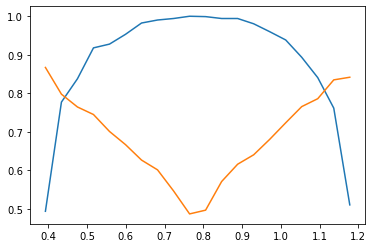

In [50]:
thetas = np.linspace(np.pi/8, 3*np.pi/8, 20)
Bobs = []
Eves = []

for k in range(len(thetas)):
    B, E = ionq_cloning('X', 0, thetas[k], False)
    Bobs.append(B)
    Eves.append(E)
    
Bobs = np.array(Bobs)
Eves = np.array(Eves)

plt.figure()
plt.plot(thetas, Bobs)
plt.plot(thetas, Eves)
plt.show()

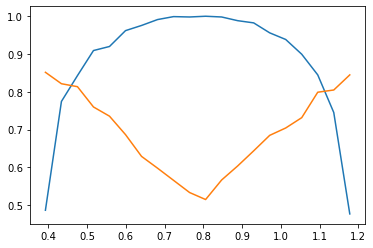

In [45]:
thetas = np.linspace(np.pi/8, 3*np.pi/8, 20)
Bobs = []
Eves = []

for k in range(len(thetas)):
    B, E = ionq_cloning('X', 1, thetas[k], False)
    Bobs.append(B)
    Eves.append(E)
    
Bobs = np.array(Bobs)
Eves = np.array(Eves)

plt.figure()
plt.plot(thetas, Bobs)
plt.plot(thetas, Eves)
plt.show()

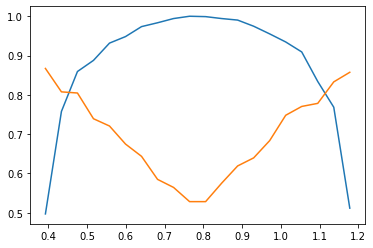

In [48]:
thetas = np.linspace(np.pi/8, 3*np.pi/8, 20)
Bobs = []
Eves = []

for k in range(len(thetas)):
    B, E = ionq_cloning('Y', 0, thetas[k], False)
    Bobs.append(B)
    Eves.append(E)
    
Bobs = np.array(Bobs)
Eves = np.array(Eves)

plt.figure()
plt.plot(thetas, Bobs)
plt.plot(thetas, Eves)
plt.show()

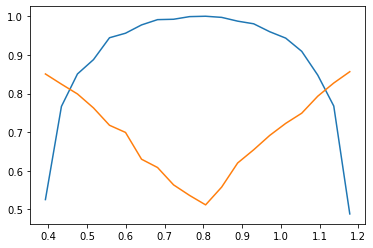

In [47]:
thetas = np.linspace(np.pi/8, 3*np.pi/8, 20)
Bobs = []
Eves = []

for k in range(len(thetas)):
    B, E = ionq_cloning('Y', 1, thetas[k], False)
    Bobs.append(B)
    Eves.append(E)
    
Bobs = np.array(Bobs)
Eves = np.array(Eves)

plt.figure()
plt.plot(thetas, Bobs)
plt.plot(thetas, Eves)
plt.show()